# Creación de redes neuronales convolucionales

En esta práctica vamos a centrarnos en crear dos redes neuronales tipo Alexnet y VGG16 para la clasificación de aceitunas, y para identificación de variedades. 

## Carga de librerías y datos

Comenzamos, como otras veces, con el preámbulo; cargamos las librerías que vamos a utilizar en este notebook.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch import optim

In [2]:
!nvidia-smi

Fri Aug 12 15:24:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   57C    P0    31W /  N/A |    931MiB / 16125MiB |     35%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Y descargamos y preparamos nuestra base de datos de aceitunas. Recordad que distinguir entre variedades es muy importante:
https://www.aceitesdeolivadeespana.com/la-importancia-de-las-variedades/

In [3]:
#@title Desarga y descompresión de datos
data_id = "variedades" #@param ["variedades", "olivenet"]

correspond = {'variedades': '1nM-EhT6ejaYtDbAvm0kbNScd6hyYzKsS', 
              'olivenet': '1-LFuqLydW7zwEFbaci54SJKTWzNIr9OU'}
if data_id=='variedades':
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1nM-EhT6ejaYtDbAvm0kbNScd6hyYzKsS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1nM-EhT6ejaYtDbAvm0kbNScd6hyYzKsS" -O 'variedades.zip' && rm -rf /tmp/cookies.txt
elif data_id=='olivenet':
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-LFuqLydW7zwEFbaci54SJKTWzNIr9OU' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-LFuqLydW7zwEFbaci54SJKTWzNIr9OU" -O 'olivenet.zip' && rm -rf /tmp/cookies.txt
else:
  print('wrong id')
!mkdir data
!unzip {data_id}.zip -d data

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: data/Variedades-JPG/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0037_6.TIFF.JPG  
  inflating: data/Variedades-JPG/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0037_7.TIFF.JPG  
  inflating: data/Variedades-JPG/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0038_1.TIFF.JPG  
  inflating: data/Variedades-JPG/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0038_3.TIFF.JPG  
  inflating: data/Variedades-JPG/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0038_6.TIFF.JPG  
  inflating: data/Variedades-JPG/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0041_2.TIFF.JPG  
  inflating: data/Variedades-JPG/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0041_7.TIFF.JPG  
  inflating: data/Variedades-JPG/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0042_5.TIFF.JPG  
  inflating: data/Variedades-JPG/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0044_2.TIFF.JPG  
  inflating: data/Variedades-JPG/ENTRENAMIENTO_45_GREYSCALE/Picual/exPicual_0044_3.TIFF.JPG  

## Creación del experimento
Antes de comenzar, es fundamental pensar bien qué queremos hacer. Comenzar a escribir código sin más es garantía de fallo. Así pues, tenemos que tener muy claras las partes fundamentales de un experimento de deep learning: 
- Carga de los datos
- Especificar los hiperparámetros
- Creación de los modelo
- Bucles de entrenamiento, validación
- Análisis de los resultados

Si somos metódicos, evitaremos errores que pueden ser debidos a descuidos. Una buena práctica es definir los hiperparámetros en el mismo lugar: 

In [3]:
# Hiperparámetros:
BATCH_SIZE=128
LR = 1e-5
IMAGE_SIZE = (256,256)
N_EPOCHS = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Al especificar ya algunos datos del entrenamiento, como el caso del `batch_size`, podemos generar los dataloaders; un tipo de objeto que nos permitirá "muestrear" el dataset en *batches*, y de esa forma realizar el forward pass en el bucle de entrenamiento. También realizaremos algunas transformaciones (preprocesamiento), como: 
- remuestrear (reducir el tamaño)
- normalizar la intensidad
- transformar a tensor de pytorch

Y otras opciones que habitualmente se usan para *data augmentation* como rotar o escalar aleatoriamente en el conjunto de entrenamiento. Así que vamos a crear, en primer lugar, el dataset y dataloader de entrenamiento:

Encontradas 7 clases: {'Arbequina': 0, 'Arbosana': 1, 'Changlot': 2, 'Lechin': 3, 'Ocal': 4, 'Picual': 5, 'Verdial': 6}


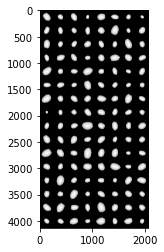

In [4]:
train_transforms = T.Compose([T.Grayscale(),
                                 T.RandomHorizontalFlip(p=0.5),
                                 T.RandomVerticalFlip(p=0.5),
                                 T.Resize(size=IMAGE_SIZE),
                                 T.ToTensor()])

'''
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomVerticalFlip(p=0.5),
                                       transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
'''
# Creamos los objetos datasets a partir de un ImageFolder de torchvision:
data_train = ImageFolder('../data/Variedades-JPG/ENTRENAMIENTO_45_GREYSCALE', transform=train_transforms) # /content/data
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Mostramos el batch de entrenamiento:
print(f'Encontradas {len(data_train.classes)} clases: {data_train.class_to_idx}')
images, labels = next(iter(train_loader))
plt.imshow(make_grid(images).permute(1, 2, 0)) 

Y a continuación el de validación:

Encontradas 7 clases: {'Arbequina': 0, 'Arbosana': 1, 'Changlot': 2, 'Lechin': 3, 'Ocal': 4, 'Picual': 5, 'Verdial': 6}


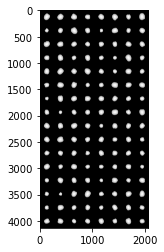

In [5]:
val_transforms = T.Compose([T.Grayscale(),
                            T.Resize(size=IMAGE_SIZE),
                            T.ToTensor()])

data_val = ImageFolder('../data/Variedades-JPG/VALIDACION_45_GREYSCALE', transform=val_transforms) # /content/data
val_loader = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=False)

# Mostramos el batch de entrenamiento:
images, labels = next(iter(val_loader))
print(f'Encontradas {len(data_val.classes)} clases: {data_val.class_to_idx}')
plt.imshow(make_grid(images).permute(1, 2, 0)) 

## Creación del modelo a usar

A continuación, queremos especificar el modelo de aprendizaje que vamos a utilizar. Para esta práctica vamos a comenzar con Alexnet. Recordemos su estructura: 
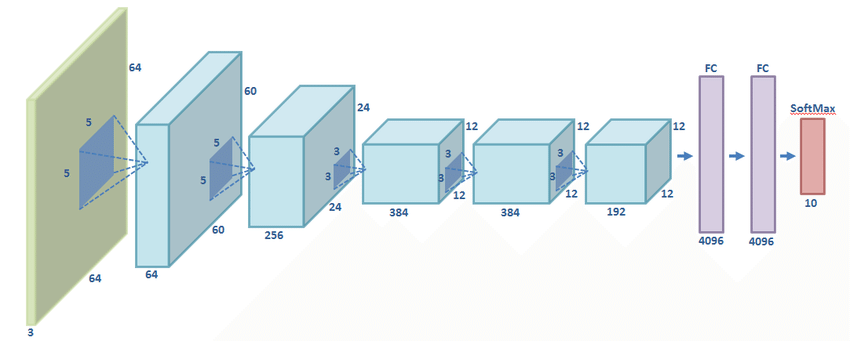 

Podemos identificar 5 capas convolucionales y 3 capas fully connected, como las del perceptrón. La estructura sería la siguiente: 
- Conv1: 64 filtros de 5x5 sin stride
- Maxpool1: stride 2
- Conv2: 256 filtros de 5x5 sin stride
- Maxpool2: stride 2
- Conv3: 384 filtros de 3x3 sin stride
- Conv4: 384 filtros de 3x3 sin stride
- Conv5: 192 filtros de 3x3 sin stride
- Reestructuración de los datos a un vector
- Fc1: Capa fully connected con 4096 neuronas
- Fc2: Capa fully connected con 4096 neuronas
- Fc3: Capa fully connected con N neuronas

Donde ese N es el número de clases. En nuestro caso, serán 2 para olivenet (aceituna, no aceituna) o 7 para el dataset de variedades de aceituna (arbequina, arbosana, changlot, lechin, ocal, picual, verdial). 

In [6]:
class AlexNet(nn.Module):
  def __init__(self, n_classes=2, input_size=48):
    super(AlexNet, self).__init__() # esta linea es siempre necesaria
    self.conv1 = nn.Conv2d(1, out_channels=64, kernel_size=5, stride=4)#, padding=2)
    in_size = (input_size-5)//4 +1
    self.conv2 = nn.Conv2d(64, out_channels=256, kernel_size=5, stride=4)#, padding=2)
    in_size = (in_size-5)//4 +1
    self.conv3 = nn.Conv2d(256, out_channels=384, kernel_size=3)#, padding=1)
    in_size = (in_size-3)+1
    self.conv4 = nn.Conv2d(384, out_channels=384, kernel_size=3)#, padding=1)
    in_size = (in_size-3)+1
    self.conv5 = nn.Conv2d(384, out_channels=192, kernel_size=3)#, padding=1)
    in_size = (in_size-3)+1
    self.fc1 = nn.LazyLinear(512)
    self.fc2 = nn.Linear(512, 1024)
    self.fc3 = nn.Linear(1024, n_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = x.view((x.shape[0],-1))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return F.softmax(self.fc3(x), dim=1)

# Prueba
model = AlexNet(n_classes=7, input_size=IMAGE_SIZE[0])
model(images[:1]).shape

/home/pakitochus/anaconda3/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([1, 7])

Alternativamente, podemos utilizar la sintaxis secuencial para generar el mismo modelo de forma más rápida. Además, es más sencillo para redes grandes compuestas de muchos bloques y muchas capas:

In [7]:
class AlexNet2(nn.Module):
  def __init__(self, n_classes=2, input_size=48):
    super(AlexNet2, self).__init__() # esta linea es siempre necesaria
    self.features = nn.Sequential(nn.Conv2d(1, out_channels=16, kernel_size=7, stride=4),
                                  nn.BatchNorm2d(16),
                                  nn.ReLU(),
                                  nn.Conv2d(16, out_channels=64, kernel_size=5, stride=4),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  nn.Conv2d(64, out_channels=128, kernel_size=3),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.Conv2d(128, out_channels=192, kernel_size=3),
                                  nn.BatchNorm2d(192),
                                  nn.ReLU(),
                                  nn.Conv2d(192, out_channels=192, kernel_size=3),
                                  nn.BatchNorm2d(192),
                                  nn.ReLU())
    in_size=9
    self.classifier = nn.Sequential(nn.LazyLinear(512),
                                    nn.ReLU(),
                                    nn.Linear(512, 1024),
                                    nn.ReLU(),
                                    nn.LazyLinear(n_classes))
    
  def forward(self, x):
    x = self.features(x)
    x = x.view((x.shape[0], -1))
    return F.softmax(self.classifier(x), dim=1)# F.log_softmax(, dim=1)

# Prueba
model = AlexNet2(n_classes=7, input_size=IMAGE_SIZE[0])
model(images).shape

torch.Size([128, 7])

## Bucle de entrenamiento

Para facilitarnos la vida vamos a crear una función `train()` que, dados un modelo, el optimizador, la función de loss y el número de epochs, entrene la red y nos devuelva un diccionario con el historial de training loss:

In [12]:
def train(model, optimizer, loss_fn, N_EPOCHS=2, early_stop=False, prefix='model_aceitunas_1108'):
  train_history={'loss': [], 'acc': []}
  max_perf = 1e11
  for e in range(N_EPOCHS):
    train_loss = 0.0 # el loss en cada epoch de entrenamiento
    train_acc = 0.0 # el accuracy de cada epoch
    total_train=0

    for ims, lbs in train_loader:
      total_train += 1
      ims = ims.to(device) # pasamos a cuda
      lbs = lbs.to(device) # pasamos a cuda

      output = model(ims) # forward pass
      loss = loss_fn(output, lbs) # calculamos el loss
      loss.backward()# backward pass
      optimizer.step() # optimización 

      train_loss += loss # acumulación para mostrar

      # predicción de la red:
      _, predicted = torch.max(output, 1) 
      train_acc += torch.sum(predicted==lbs)/lbs.shape[0] # y acumulamos el número de correctos
    ls_val = (train_loss/total_train).detach().cpu().numpy()
    acc_val = (train_acc/total_train).detach().cpu().numpy()
    if early_stop and (-acc_val < max_perf):
      max_perf = -acc_val
      torch.save(model, f'{prefix}_{e}e.mdl')
    train_history['loss'].append(ls_val)
    train_history['acc'].append(acc_val)
    print(f'Epoch {e}: Loss: {train_loss/total_train}, acc: {train_acc/total_train}')
    
  return train_history

Ahora definiremos nuestra red, el optimizador y la función de pérdida:

In [16]:
model = AlexNet2(n_classes=len(data_val.classes), input_size=IMAGE_SIZE[0])
model = model.to(device) # pasamos a cuda
# model = torch.load('model_aceitunas_2207_3360e.mdl')
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-6)
# optimizer = optim.SGD(model.parameters(), lr=1e-6, momentum=0.9)
history = train(model, optimizer, loss_fn, 200, early_stop=True)

/home/pakitochus/anaconda3/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 0: Loss: 1.937968373298645, acc: 0.2827598750591278
Epoch 1: Loss: 1.9119791984558105, acc: 0.4090067446231842
Epoch 2: Loss: 1.8684873580932617, acc: 0.3583175539970398
Epoch 3: Loss: 1.8179982900619507, acc: 0.34888994693756104
Epoch 4: Loss: 1.781529188156128, acc: 0.37974536418914795
Epoch 5: Loss: 1.7545280456542969, acc: 0.4023805558681488
Epoch 6: Loss: 1.7317700386047363, acc: 0.45396149158477783
Epoch 7: Loss: 1.710538387298584, acc: 0.48277565836906433
Epoch 8: Loss: 1.6932655572891235, acc: 0.49221116304397583
Epoch 9: Loss: 1.6762808561325073, acc: 0.508893609046936
Epoch 10: Loss: 1.6645901203155518, acc: 0.5128551125526428
Epoch 11: Loss: 1.6545491218566895, acc: 0.5182843804359436
Epoch 12: Loss: 1.6477152109146118, acc: 0.5262442231178284
Epoch 13: Loss: 1.6419953107833862, acc: 0.5316261649131775
Epoch 14: Loss: 1.6366230249404907, acc: 0.52809077501297
Epoch 15: Loss: 1.6289063692092896, acc: 0.5327388048171997
Epoch 16: Loss: 1.6276946067810059, acc: 0.53844171

Para ver como se comporta sobre el conjunto de test, creamos otra función que nos ayude

In [25]:
model = torch.load('model_aceitunas_1108_153e.mdl')

In [9]:
def test(model, optimizer, loss_fn):
  with torch.no_grad():
    test_history={'loss': [], 'acc': [], 'ytrue': [], 'preds': []}

    for ims, lbs in val_loader:
      ims = ims.to(device) # pasamos a cuda
      lbs = lbs.to(device) # pasamos a cuda

      output = model(ims) # forward pass
      loss = loss_fn(output, lbs) # calculamos el loss
      test_history['loss'].append(loss.item()) # acumulación para mostrar

      # predicción de la red:
      _, predicted = torch.max(output, 1) 
      test_history['ytrue'].append(lbs.detach().cpu().numpy())
      test_history['preds'].append(predicted.detach().cpu().numpy())
      test_history['acc'].append((predicted==lbs).detach().cpu().numpy().mean()) # y acumulamos el número de correctos
    
    loss_sum = sum(test_history['loss'])/len(test_history['loss'])
    acc_sum = sum(test_history['acc'])/len(test_history['acc'])
    print(f'Validacion: Loss: {loss_sum}, acc: {acc_sum}')
  return test_history


In [27]:
test_outputs = test(model, optimizer, loss_fn)

Validacion: Loss: 1.404089879989624, acc: 0.7569711538461539


## Interpretando los resultados
En general, es habitual dejarlo aquí. Tenemos unos números muy buenos, no? Pues ale, a otra cosa. Sin embargo, a partir de estas redes neuronales ya entrenadas podemos extraer mucha más información. Para empezar, un aspecto clave son las curvas de entrenamiento: 

In [21]:
history['loss'] = [el.item() for el in history['loss']]

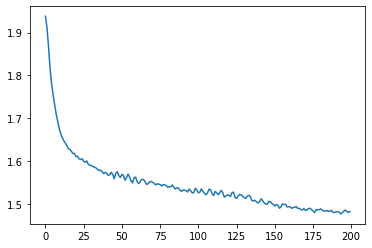

In [22]:
plt.plot(history['loss'])

Estas curvas nos muestran como el loss va decreciendo a lo largo de las diferentes epochs. Podemos hacer lo mismo para el historial del accuracy (que no tiene por qué ser igual que el *loss*):


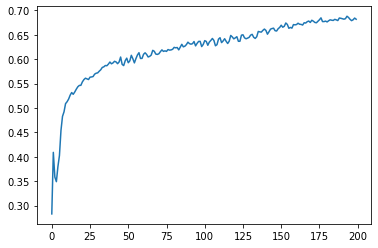

In [23]:
plt.plot(history['acc'])

Asimismo, otro indicador acerca de las predicciones de nuestro modelo es la "matriz de confusión" (lo encontraréis como *confussion matrix*). En este caso vamos a utilizar una librería bien conocida por los 

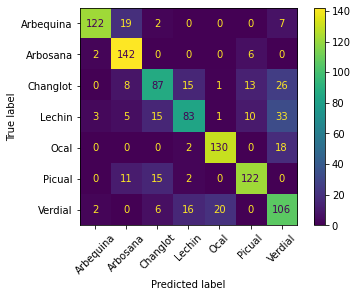

In [28]:
import numpy as np 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = np.concatenate(test_outputs['ytrue'])
y_pred = np.concatenate(test_outputs['preds'])

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_train.classes)
disp.plot(xticks_rotation=45) 

¿Qué conclusiones podemos extraer de aquí?

## Transfer learning
Entrenar una red es costoso en tiempo y recursos. Hoy en día existen miles de redes ya entrenadas que podemos utilizar para nuestros proyectos, tan solo cambiando su propósito. A este procedimiento se conoce como *Transfer Learning*. 

In [32]:
from types import new_class
import torchvision
model = torchvision.models.squeezenet1_1(pretrained=True)
old_input_layer = model.features[0]
model.features[0] = nn.Conv2d(1, old_input_layer.out_channels, 
                                kernel_size=old_input_layer.kernel_size,
                                stride = old_input_layer.stride,
                                padding=old_input_layer.padding)
state_dict = old_input_layer.state_dict()
state_dict['weight'] = state_dict['weight'][:,0:1]
model.features[0].load_state_dict(state_dict)
for par in model.features.parameters():
    par.requires_grad=False

model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Conv2d(512, 7, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(output_size=(1, 1))
  )

In [33]:
model = model.to(device) # pasamos a cuda
# model = torch.load('model_aceitunas_2207_3360e.mdl')
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=1e-6, momentum=0.9)
history_2 = train(model, optimizer, loss_fn, 200, early_stop=True, prefix='squeeze_1208')

Epoch 0: Loss: 1.9111064672470093, acc: 0.22360259294509888
Epoch 1: Loss: 1.7434988021850586, acc: 0.319229394197464
Epoch 2: Loss: 1.6784790754318237, acc: 0.339138925075531
Epoch 3: Loss: 1.6971498727798462, acc: 0.3330625295639038
Epoch 4: Loss: 1.5617042779922485, acc: 0.41202110052108765
Epoch 5: Loss: 1.6262859106063843, acc: 0.35627439618110657
Epoch 6: Loss: 1.534242033958435, acc: 0.42471539974212646
Epoch 7: Loss: 1.4942760467529297, acc: 0.4153366982936859
Epoch 8: Loss: 1.5423694849014282, acc: 0.3612862825393677
Epoch 9: Loss: 1.5118120908737183, acc: 0.3677104413509369
Epoch 10: Loss: 1.4405940771102905, acc: 0.4447656571865082
Epoch 11: Loss: 1.44920015335083, acc: 0.45982787013053894
Epoch 12: Loss: 1.4884953498840332, acc: 0.4428861439228058
Epoch 13: Loss: 1.4045541286468506, acc: 0.4594429135322571
Epoch 14: Loss: 1.4618198871612549, acc: 0.42083704471588135
Epoch 15: Loss: 1.449264645576477, acc: 0.40206632018089294
Epoch 16: Loss: 1.4262361526489258, acc: 0.419207

KeyboardInterrupt: 

In [34]:
model = torch.load('squeeze_1208_34e.mdl')

In [35]:
test_outputs = test(model, optimizer, loss_fn)

Validacion: Loss: 1.0416856010754902, acc: 0.6140491452991452


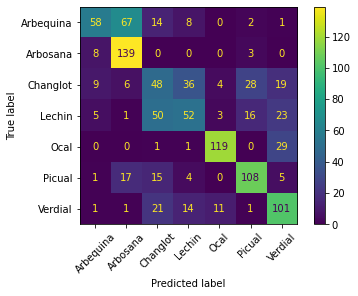

In [36]:
import numpy as np 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = np.concatenate(test_outputs['ytrue'])
y_pred = np.concatenate(test_outputs['preds'])

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_train.classes)
disp.plot(xticks_rotation=45) 